<a href="https://colab.research.google.com/github/Sivani-2/IPL-Infographics/blob/main/Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [2]:
matches=pd.read_csv('matches.csv')
#data preparation
matches['date']=pd.to_datetime(matches['date'])
matches.head(5)

,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
1,335983,2007/08,Chandigarh,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,241.0,20.0,N,NaN,MR Benson,SL Shastri
2,335984,2007/08,Delhi,2008-04-19,League,MF Maharoof,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,130.0,20.0,N,NaN,Aleem Dar,GA Pratapkumar
3,335985,2007/08,Mumbai,2008-04-20,League,MV Boucher,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,166.0,20.0,N,NaN,SJ Davis,DJ Harper
4,335986,2007/08,Kolkata,2008-04-20,League,DJ Hussey,Eden Gardens,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,111.0,20.0,N,NaN,BF Bowden,K Hariharan


In [3]:
#reshape and calculate team metrics
team_performance=matches.melt(
    id_vars=["id","season","date","winner","result","result_margin","target_runs"],
    value_vars=["team1","team2"],
    var_name="home_or_away",
    value_name="team"
)

team_performance['is_winner']=(team_performance["team"]==team_performance["winner"]).astype(int)
team_performance['runs_scored']=team_performance['target_runs']
team_performance['runs_conceded']=team_performance.groupby('id')["target_runs"].transform("sum")-team_performance['target_runs']

team_performance.head(5)

,id,season,date,winner,result,result_margin,target_runs,home_or_away,team,is_winner,runs_scored,runs_conceded
0,335982,2007/08,2008-04-18,Kolkata Knight Riders,runs,140.0,223.0,team1,Royal Challengers Bangalore,0,223.0,223.0
1,335983,2007/08,2008-04-19,Chennai Super Kings,runs,33.0,241.0,team1,Kings XI Punjab,0,241.0,241.0
2,335984,2007/08,2008-04-19,Delhi Daredevils,wickets,9.0,130.0,team1,Delhi Daredevils,1,130.0,130.0
3,335985,2007/08,2008-04-20,Royal Challengers Bangalore,wickets,5.0,166.0,team1,Mumbai Indians,0,166.0,166.0
4,335986,2007/08,2008-04-20,Kolkata Knight Riders,wickets,5.0,111.0,team1,Kolkata Knight Riders,1,111.0,111.0


In [4]:
#aggregated data for each team
team_performance_agg=team_performance.groupby(['team',"date"]).agg({
    "is_winner":"sum",
    "runs_scored":"sum",
    "runs_conceded":"sum"
}).sort_values("date").reset_index()
team_performance_agg["net_run_rate"]=team_performance_agg["runs_scored"]-team_performance_agg["runs_conceded"]
team_performance_agg.head(5)

,team,date,is_winner,runs_scored,runs_conceded,net_run_rate
0,Royal Challengers Bangalore,2008-04-18,0,223.0,223.0,0.0
1,Kolkata Knight Riders,2008-04-18,1,223.0,223.0,0.0
2,Delhi Daredevils,2008-04-19,1,130.0,130.0,0.0
3,Rajasthan Royals,2008-04-19,0,130.0,130.0,0.0
4,Kings XI Punjab,2008-04-19,0,241.0,241.0,0.0


In [5]:
team_name="Kolkata Knight Riders"
team_data=team_performance_agg[team_performance_agg["team"]==team_name]
team_data

,team,date,is_winner,runs_scored,runs_conceded,net_run_rate
1,Kolkata Knight Riders,2008-04-18,1,223.0,223.0,0.0
8,Kolkata Knight Riders,2008-04-20,1,111.0,111.0,0.0
22,Kolkata Knight Riders,2008-04-26,0,148.0,148.0,0.0
30,Kolkata Knight Riders,2008-04-29,0,138.0,138.0,0.0
36,Kolkata Knight Riders,2008-05-01,0,197.0,197.0,0.0
...,...,...,...,...,...,...
2149,Kolkata Knight Riders,2024-05-03,1,170.0,170.0,0.0
2152,Kolkata Knight Riders,2024-05-05,1,236.0,236.0,0.0
2167,Kolkata Knight Riders,2024-05-11,1,158.0,158.0,0.0
2182,Kolkata Knight Riders,2024-05-21,1,160.0,160.0,0.0


In [6]:
team_data=team_data.sort_values("date")

team_data.set_index(["date"],inplace=True)
team_data

,team,is_winner,runs_scored,runs_conceded,net_run_rate
date,,,,,
2008-04-18,Kolkata Knight Riders,1,223.0,223.0,0.0
2008-04-20,Kolkata Knight Riders,1,111.0,111.0,0.0
2008-04-26,Kolkata Knight Riders,0,148.0,148.0,0.0
2008-04-29,Kolkata Knight Riders,0,138.0,138.0,0.0
2008-05-01,Kolkata Knight Riders,0,197.0,197.0,0.0
...,...,...,...,...,...
2024-05-03,Kolkata Knight Riders,1,170.0,170.0,0.0
2024-05-05,Kolkata Knight Riders,1,236.0,236.0,0.0
2024-05-11,Kolkata Knight Riders,1,158.0,158.0,0.0


In [7]:
#column to predict
time_series=team_data["runs_scored"]

# Stationarity Check (ADF(Augmented Dickey-Fuller) Test)
adf_result=adfuller(time_series)
print("ADF Statistic:", adf_result[0])
print("p-value:",adf_result[1])
if adf_result[1]>0.05:
    print("The series is not stationary. Differencing is required.")
# A stationary time series has constant mean and variance over time.

ADF Statistic: -7.214074913565808
p-value: 2.1963196715516396e-10


In [8]:
#Differencing (if necessary): If the ADF test's p-value is greater than 0.05,
# it suggests the time series is not stationary.
# The code then calculates the first difference of the time series (time_series_diff) to make it stationary.
# Differencing subtracts the previous value from the current value.

if adf_result[1] >0.05:
  time_series_diff=time_series.diff().dropna()
else:
  time_series_diff=time_series

In [9]:
# Spltting the time_series_diff data
train_size=int(len(time_series_diff)*0.8)

train,test=time_series_diff[:train_size],time_series_diff[train_size:]

In [10]:
#Building the model
model=ARIMA(train,order=(1,1,1))
fitted_model=model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [11]:
#Predicting/Forecasting the outputs on test data
forecast=fitted_model.forecast(steps=len(test))
forecast.index=test.index
forecast.head(5)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,predicted_mean
date,
2021-09-23,160.975878
2021-09-26,166.173245
2021-09-28,166.570630
2021-10-01,166.601014
2021-10-03,166.603337


In [12]:
#testing the model using evaluation metrics
actual_runs=test.values
forecast_runs=forecast.values

mae=np.mean(np.abs(actual_runs-forecast_runs))
print(f"Mean Absolute Error (MAE):",mae)
rmse=np.sqrt(np.mean((actual_runs-forecast_runs)**2))
print(f"Root Mean Squared Error (RMSE):",rmse)

Mean Absolute Error (MAE): 28.84228337144472
Root Mean Squared Error (RMSE): 37.5213765172496


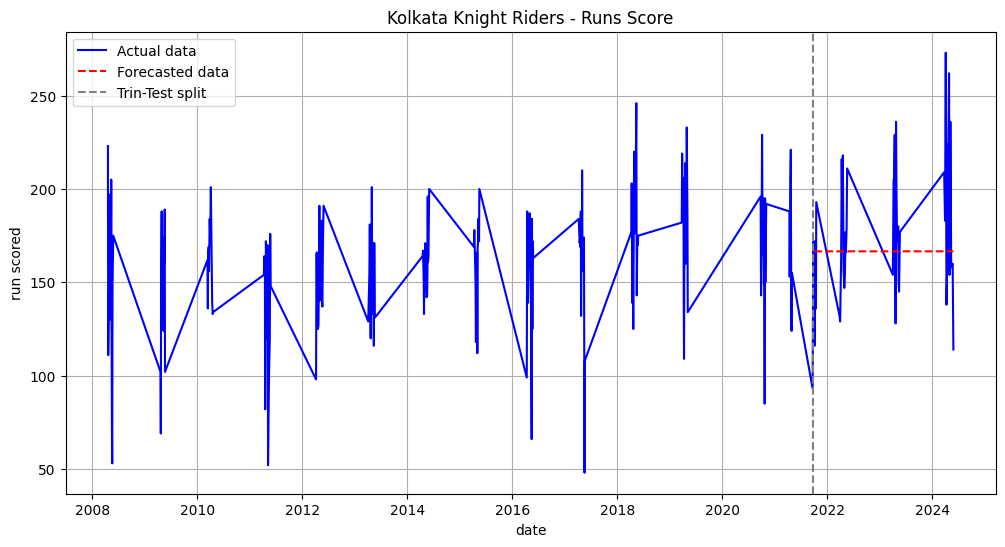

In [13]:
#Displaying the results
plt.figure(figsize = (12, 6))
plt.plot(time_series_diff , label ="Actual data" , color ="blue")
plt.plot(forecast ,label ="Forecasted data" , color="red", linestyle ="--")
plt.axvline(x =test.index[0], color="gray", linestyle = "--",label = "Trin-Test split")
plt.title(f"{team_name} - Runs Score")
plt.xlabel("date")
plt.ylabel("run scored")
plt.legend()
plt.grid()
plt.show()

In [14]:
deliveries=pd.read_csv('deliveries.csv')

In [15]:
#filter the data
kohli_scores=deliveries[deliveries['batter']=='V Kohli']

In [16]:
kohli_matchwise_scores=kohli_scores.groupby('match_id')['batsman_runs'].sum().reset_index()

In [17]:
kohli_matchwise_scores_subset=kohli_matchwise_scores.head(239)
kohli_matchwise_scores_subset

,match_id,batsman_runs
0,335982,1
1,335985,23
2,335992,13
3,335996,12
4,335998,1
...,...,...
234,1426263,3
235,1426268,42
236,1426274,18
237,1426279,51


In [18]:
kohli_matchwise_scores_subset["match_number"]=range(len(kohli_matchwise_scores_subset))
kohli_matchwise_scores_subset.set_index("match_number",inplace=True)

<ipython-input-18-c152b76d3237>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kohli_matchwise_scores_subset["match_number"]=range(len(kohli_matchwise_scores_subset))


In [19]:
model=ARIMA(kohli_matchwise_scores_subset["batsman_runs"],order=(1,1,1))
model_fitted=model.fit()

In [20]:
forecast=model_fitted.forecast(steps=5)
#steps indicate the next 5 matches
forecast

,predicted_mean
239,45.064196
240,44.510021
241,44.497705
242,44.497431
243,44.497425


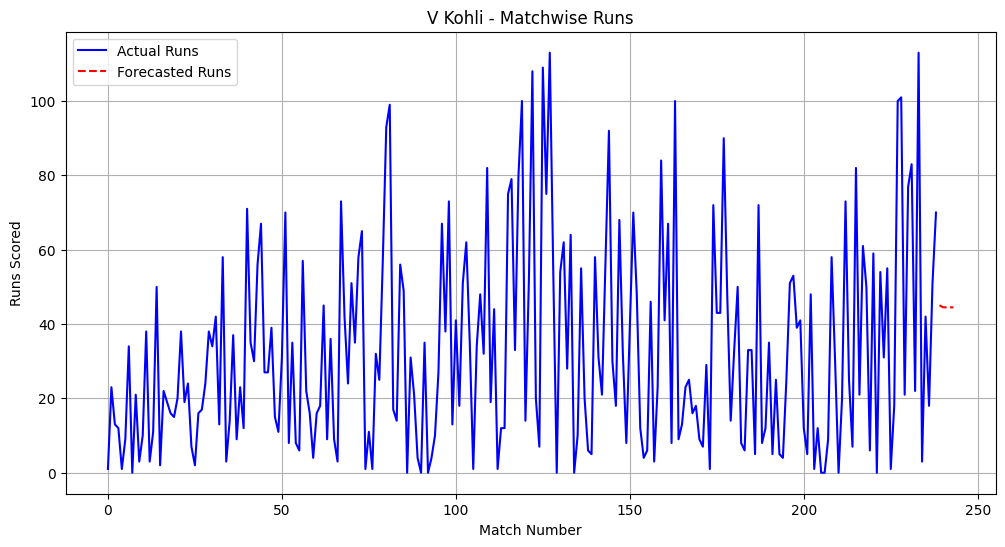

In [21]:
# Displaying the results for Kohli
plt.figure(figsize=(12, 6))
plt.plot(kohli_matchwise_scores_subset["batsman_runs"], label="Actual Runs", color="blue")
plt.plot(forecast, label="Forecasted Runs", color="red", linestyle="--")
plt.title("V Kohli - Matchwise Runs")
plt.xlabel("Match Number")
plt.ylabel("Runs Scored")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# runs per batsman and match
batsman_scores=deliveries.groupby(['match_id','batter']).agg({'batsman_runs':'sum'}).reset_index()

# total runs per batsman
total_runs_per_batsman=batsman_scores.groupby('batter')['batsman_runs'].sum().reset_index()
total_runs_per_batsman=total_runs_per_batsman.sort_values('batsman_runs',ascending=False)

# top 10 batsman
top_10_batsmen=total_runs_per_batsman.head(10)
top_10_batsmen

,batter,batsman_runs
631,V Kohli,8014
512,S Dhawan,6769
477,RG Sharma,6630
147,DA Warner,6567
546,SK Raina,5536
374,MS Dhoni,5243
30,AB de Villiers,5181
124,CH Gayle,4997
501,RV Uthappa,4954
282,KD Karthik,4843


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

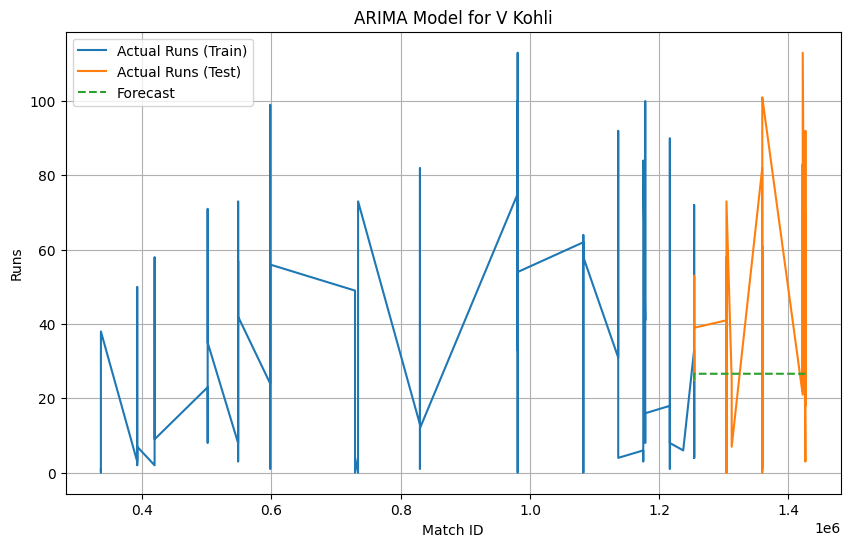

Batsman: V Kohli, MAE: 25.49455584853502


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

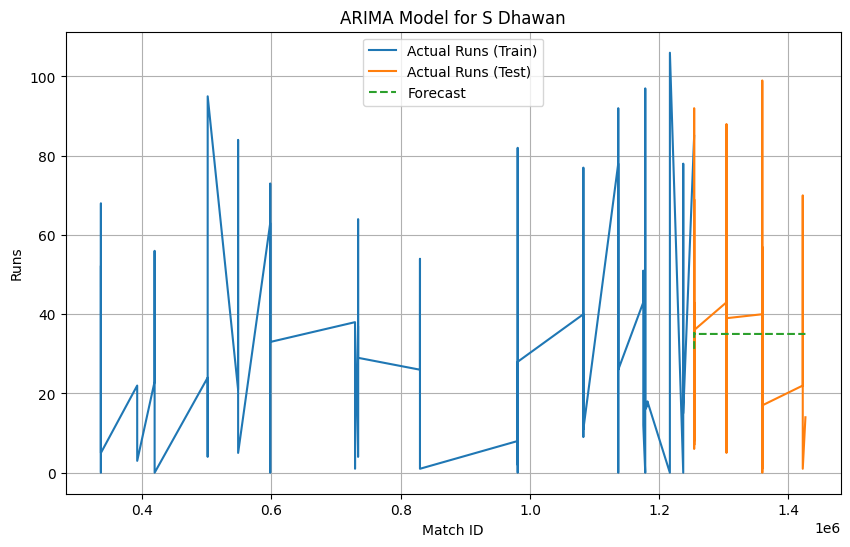

Batsman: S Dhawan, MAE: 21.69183992169749


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

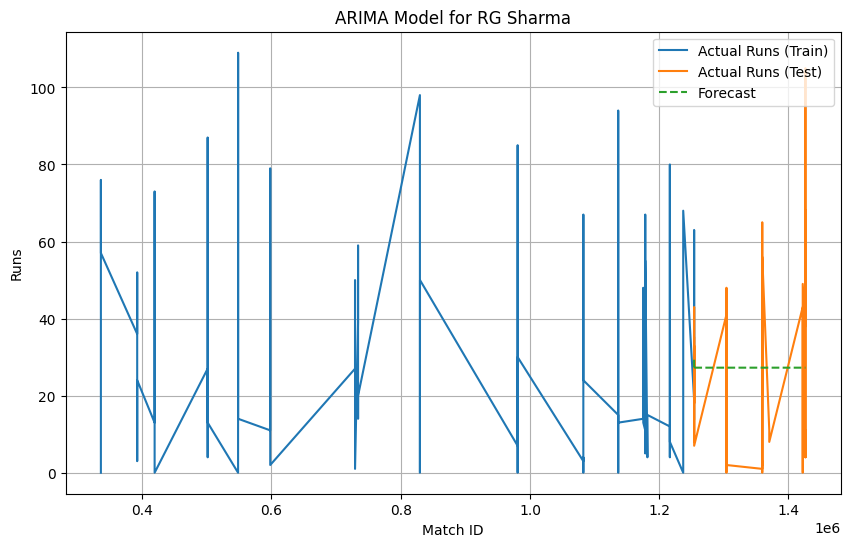

Batsman: RG Sharma, MAE: 18.246250065380263


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

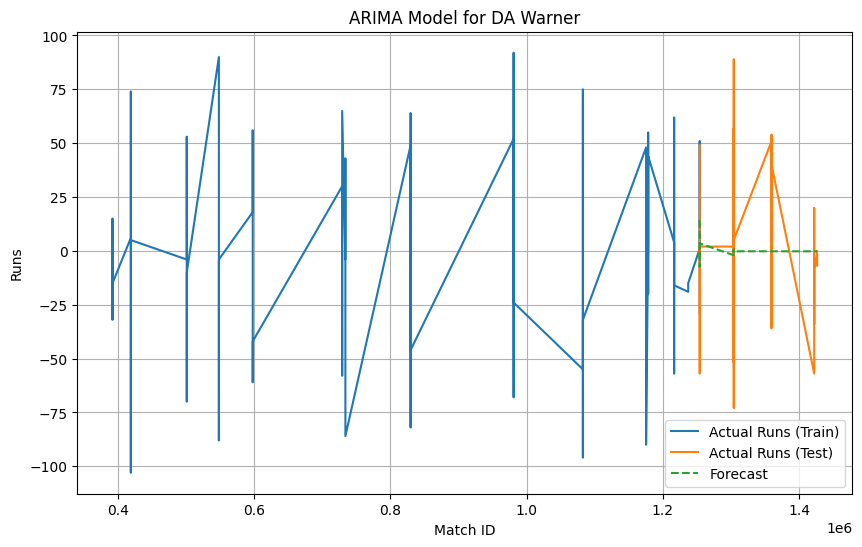

Batsman: DA Warner, MAE: 27.299710037045507


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

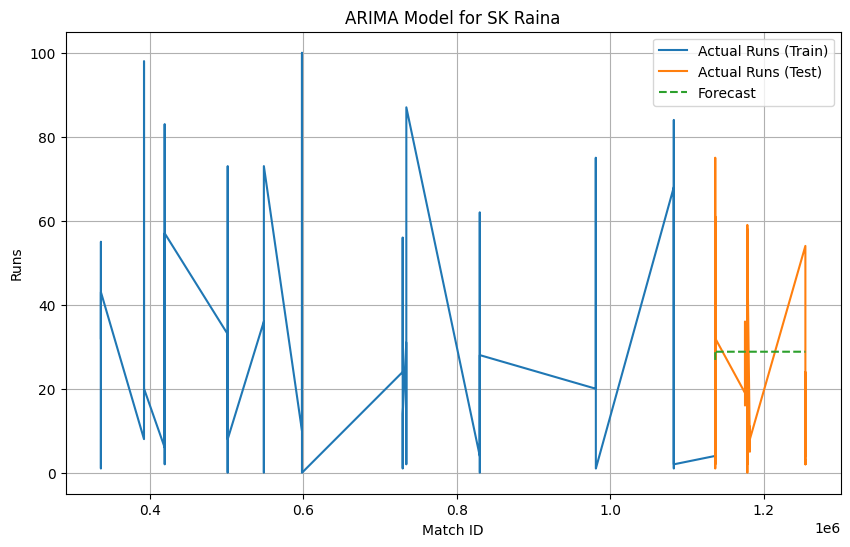

Batsman: SK Raina, MAE: 18.688334116662833


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

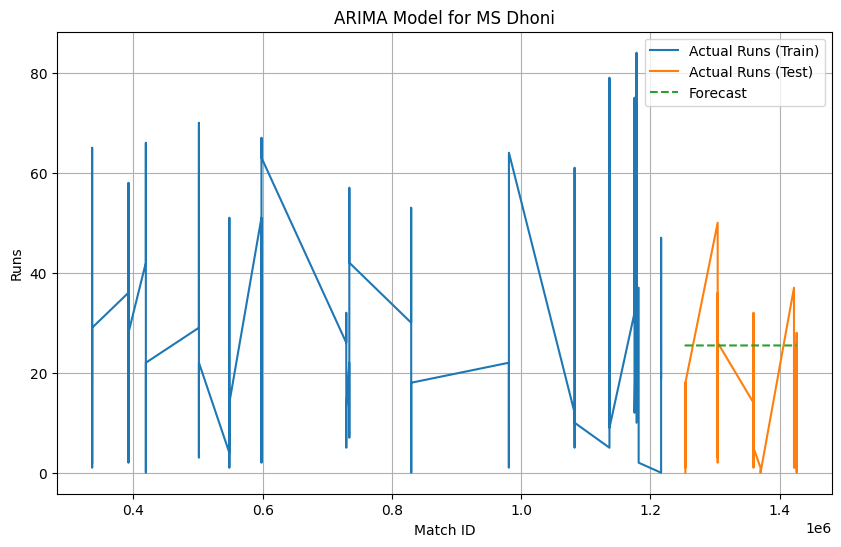

Batsman: MS Dhoni, MAE: 14.75263423907063


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

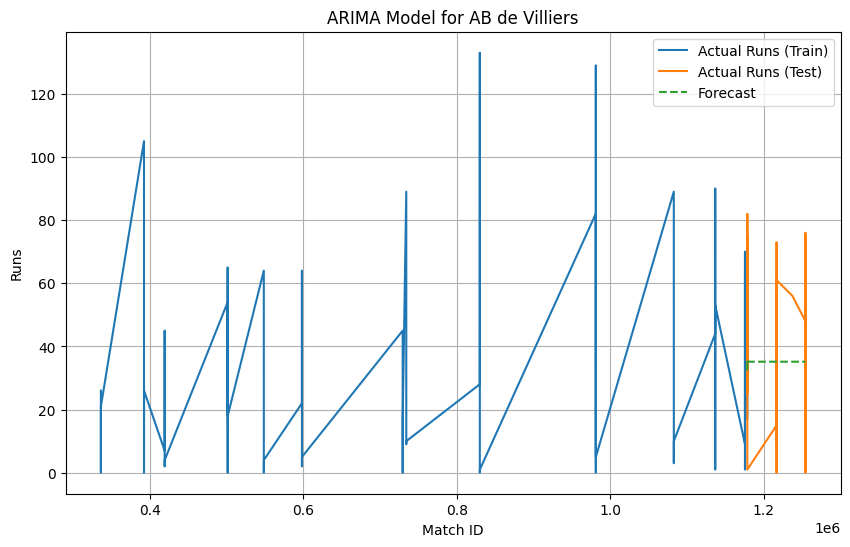

Batsman: AB de Villiers, MAE: 24.237999661757524


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

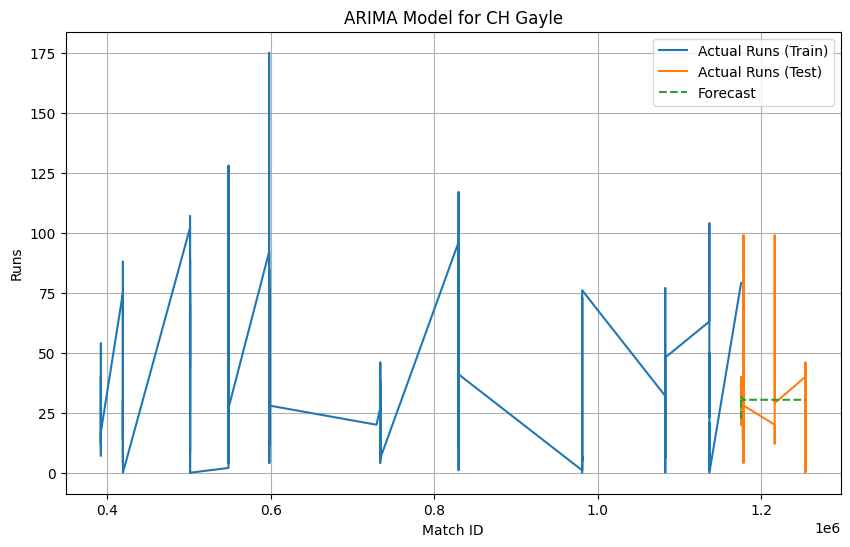

Batsman: CH Gayle, MAE: 19.733679311667377


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

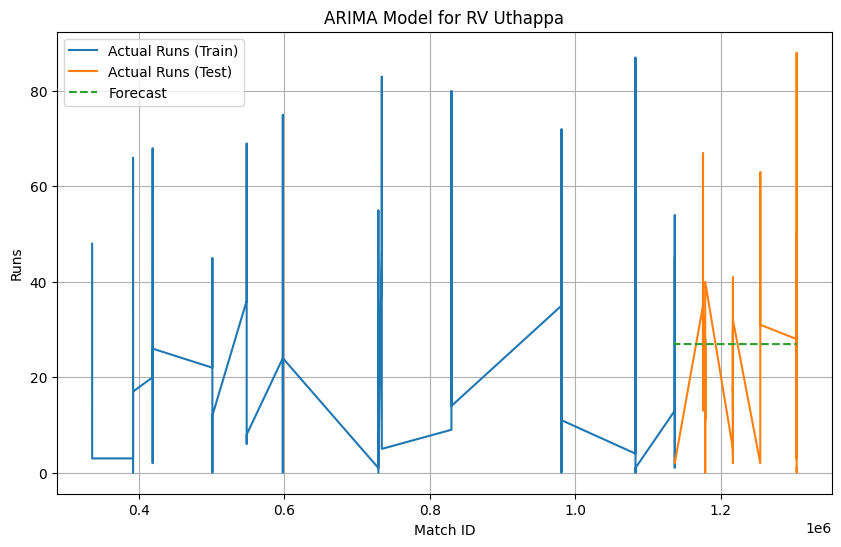

Batsman: RV Uthappa, MAE: 17.147227034929195


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

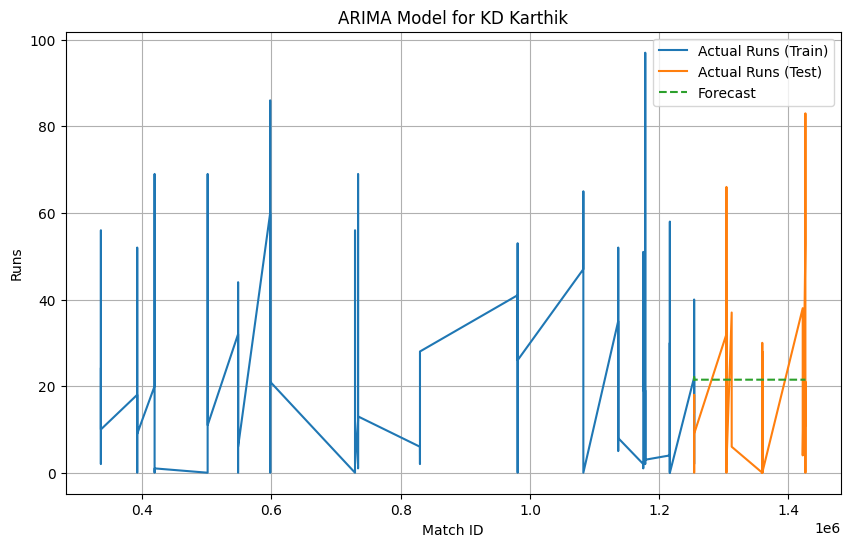

Batsman: KD Karthik, MAE: 14.277295724712504


In [23]:
for i in range(len(top_10_batsmen)):
    batsman_name = top_10_batsmen.iloc[i]['batter']
    batsman_data = batsman_scores[batsman_scores['batter'] == batsman_name].set_index('match_id')['batsman_runs']

    # Stationarity Check
    adf_result = adfuller(batsman_data)
    if adf_result[1] > 0.05:
        batsman_data = batsman_data.diff().dropna()

    # Split data
    train_size = int(len(batsman_data) * 0.8)
    train, test = batsman_data[:train_size], batsman_data[train_size:]

    # ARIMA model
    try:
        model = ARIMA(train, order=(1, 1, 1))  # Adjust order if needed
        fitted_model = model.fit()
        forecast = fitted_model.forecast(steps=len(test))
        forecast.index = test.index

        # Create the plot
        plt.figure(figsize=(10, 6))
        plt.plot(train, label='Actual Runs (Train)')
        plt.plot(test, label='Actual Runs (Test)')
        plt.plot(forecast, label='Forecast', linestyle='--')
        plt.title(f'ARIMA Model for {batsman_name}')
        plt.xlabel('Match ID')
        plt.ylabel('Runs')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Evaluation metrics
        mae = np.mean(np.abs(test.values - forecast.values))
        print(f"Batsman: {batsman_name}, MAE: {mae}")

    except Exception as e:
        print(f"Error fitting ARIMA model for {batsman_name}: {e}")

In [24]:
deliveries=pd.read_csv('deliveries.csv')

In [25]:
# Preprocess data to calculate bowling performance metrics
bowler_data=deliveries[['match_id', 'bowler', 'is_wicket', 'total_runs']]

In [26]:
# Aggregate data by match and bowler
performance=bowler_data.groupby(['match_id','bowler']).agg(
    wickets=('is_wicket','sum'),  # Total wickets per match
    runs_conceded=('total_runs','sum')  # Total runs conceded per match
).reset_index()

In [27]:
# Aggregate performance metrics for each bowler across matches
bowler_summary = performance.groupby('bowler').agg(
    total_wickets=('wickets', 'sum'),
    total_runs_conceded=('runs_conceded', 'sum'),
    matches_played=('match_id', 'nunique')
).reset_index()

In [28]:
# Calculate additional metrics
bowler_summary['average_runs_conceded'] = bowler_summary['total_runs_conceded'] / bowler_summary['matches_played']
bowler_summary['wickets_per_match'] = bowler_summary['total_wickets'] / bowler_summary['matches_played']

In [29]:
# Sort bowlers by total wickets and select the top 10
top_bowlers = bowler_summary.sort_values(by='total_wickets', ascending=False).head(10)
top_bowlers

,bowler,total_wickets,total_runs_conceded,matches_played,average_runs_conceded,wickets_per_match
524,YS Chahal,213,4681,159,29.440252,1.339623
119,DJ Bravo,207,4436,158,28.075949,1.310127
348,PP Chawla,201,5179,191,27.115183,1.052356
446,SP Narine,200,4672,175,26.697143,1.142857
355,R Ashwin,198,5435,208,26.129808,0.951923
71,B Kumar,195,5051,176,28.698864,1.107955
438,SL Malinga,188,3486,122,28.573770,1.540984
8,A Mishra,183,4193,162,25.882716,1.129630
193,JJ Bumrah,182,3840,133,28.872180,1.368421
373,RA Jadeja,169,4917,211,23.303318,0.800948


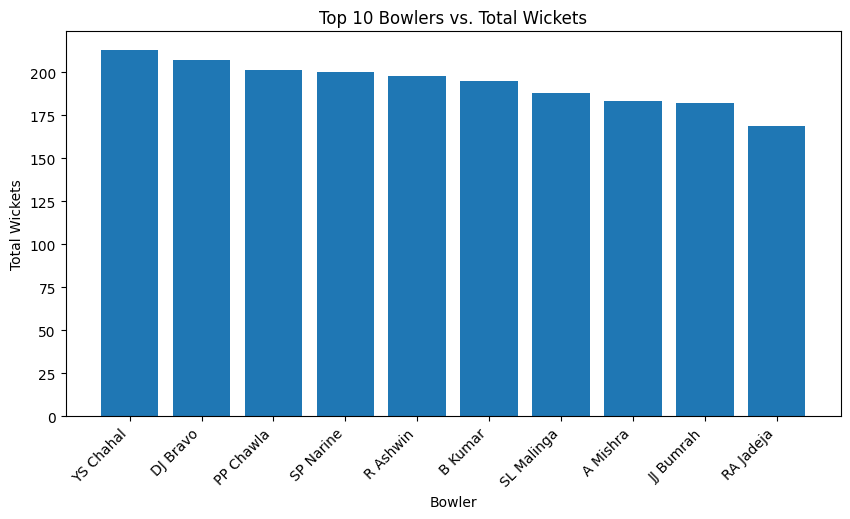

In [30]:
plt.figure(figsize=(10, 5))
plt.bar(top_bowlers['bowler'], top_bowlers['total_wickets'])
plt.xlabel("Bowler")
plt.ylabel("Total Wickets")
plt.title("Top 10 Bowlers vs. Total Wickets")
plt.xticks(rotation=45, ha='right')
plt.show()

In [31]:
# Choose a bowler to analyze
top_bowler='YS Chahal'
bowler_timeseries=performance[performance['bowler'] == top_bowler].set_index('match_id')['wickets']
print(bowler_timeseries)
# Sort the series by match_id (to ensure chronological order)
bowler_timeseries=bowler_timeseries.sort_index()

match_id
598029     0
729281     1
729287     2
729299     1
729305     1
          ..
1426294    1
1426299    1
1426303    2
1426310    1
1426311    0
Name: wickets, Length: 159, dtype: int64


In [32]:
# Train an ARIMA model on the bowler's wickets per match
model=ARIMA(bowler_timeseries, order=(2, 1, 2))  # ARIMA(p=2, d=1, q=2)
model_fit=model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

In [33]:
# Forecast wickets for the next 10 matches
forecast_steps=10
forecast=model_fit.forecast(steps=forecast_steps)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


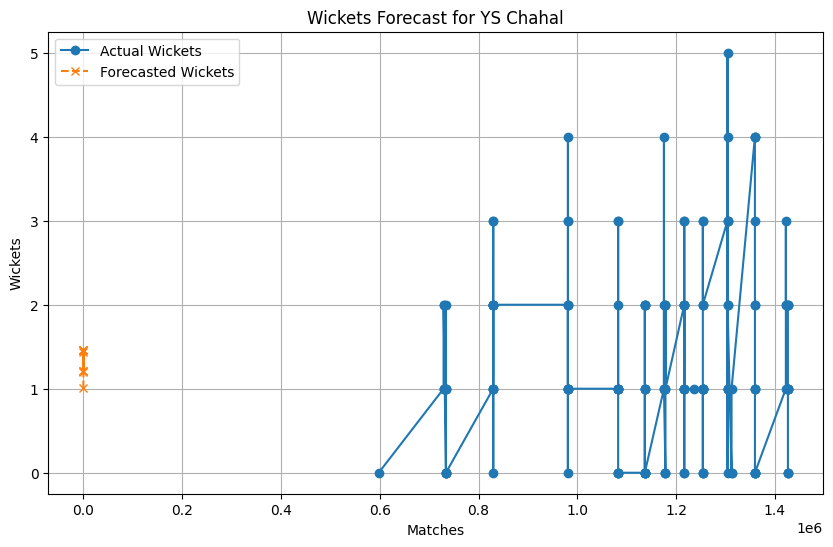

In [34]:
# Plot the actual vs forecasted values
plt.figure(figsize=(10, 6))
plt.plot(bowler_timeseries, label='Actual Wickets', marker='o')
plt.plot(range(len(bowler_timeseries), len(bowler_timeseries) + forecast_steps), forecast, label='Forecasted Wickets', marker='x', linestyle='--')
plt.title(f'Wickets Forecast for {top_bowler}')
plt.xlabel('Matches')
plt.ylabel('Wickets')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
# Print forecasted values
print(f"Forecasted wickets for the next {forecast_steps} matches:")
print(forecast)

Forecasted wickets for the next 10 matches:
159    1.005454
160    1.437802
161    1.202628
162    1.464834
163    1.206342
164    1.465336
165    1.206418
166    1.465339
167    1.206425
168    1.465333
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

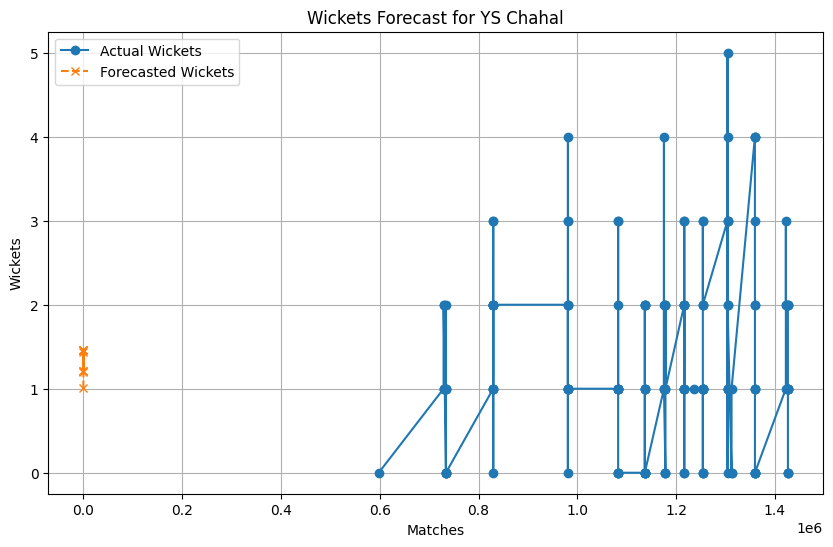

Forecasted wickets for YS Chahal in the next 10 matches:
159    1.005454
160    1.437802
161    1.202628
162    1.464834
163    1.206342
164    1.465336
165    1.206418
166    1.465339
167    1.206425
168    1.465333
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

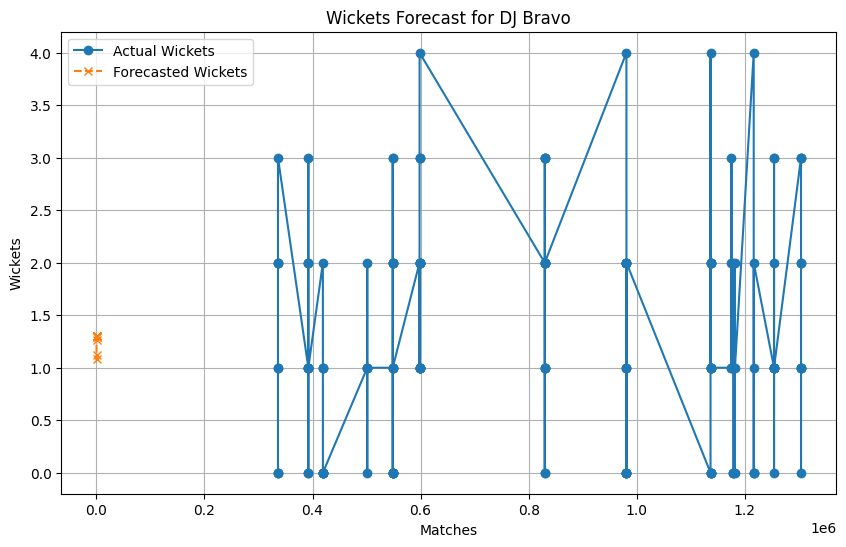

Forecasted wickets for DJ Bravo in the next 10 matches:
158    1.123336
159    1.080509
160    1.290551
161    1.263417
162    1.304446
163    1.295703
164    1.304033
165    1.301664
166    1.303410
167    1.302815
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

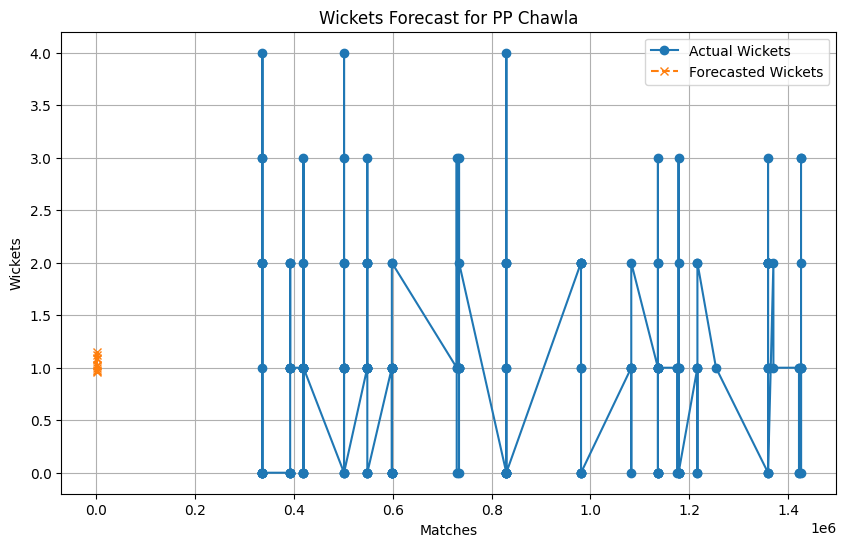

Forecasted wickets for PP Chawla in the next 10 matches:
191    0.976358
192    0.955228
193    1.148731
194    0.972775
195    1.117782
196    0.999699
197    1.095708
198    1.017662
199    1.081105
200    1.029533
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

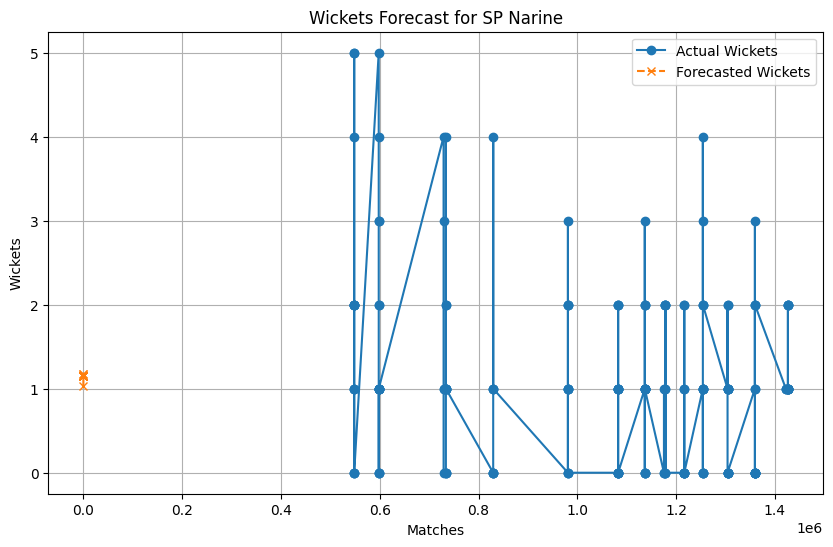

Forecasted wickets for SP Narine in the next 10 matches:
175    1.036566
176    1.181101
177    1.173002
178    1.151011
179    1.152631
180    1.155970
181    1.155665
182    1.155158
183    1.155214
184    1.155291
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

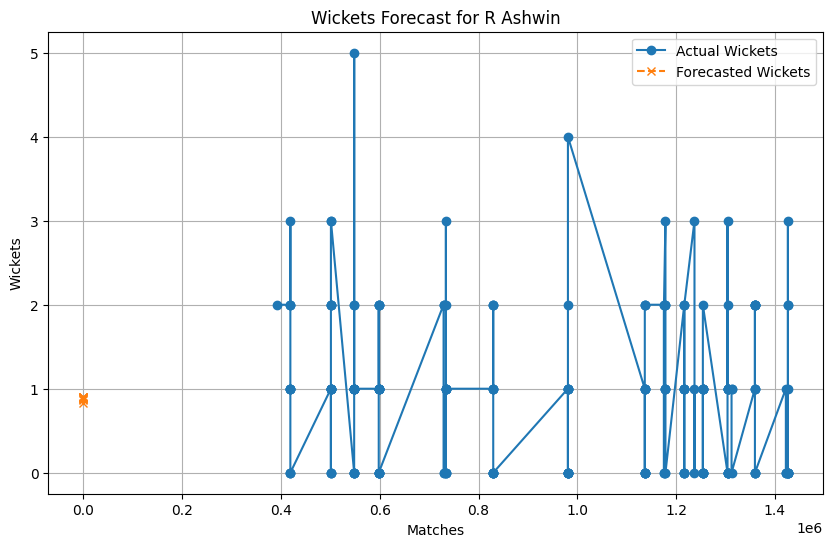

Forecasted wickets for R Ashwin in the next 10 matches:
208    0.829370
209    0.864865
210    0.906687
211    0.877625
212    0.903352
213    0.881240
214    0.900307
215    0.883871
216    0.898039
217    0.885826
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

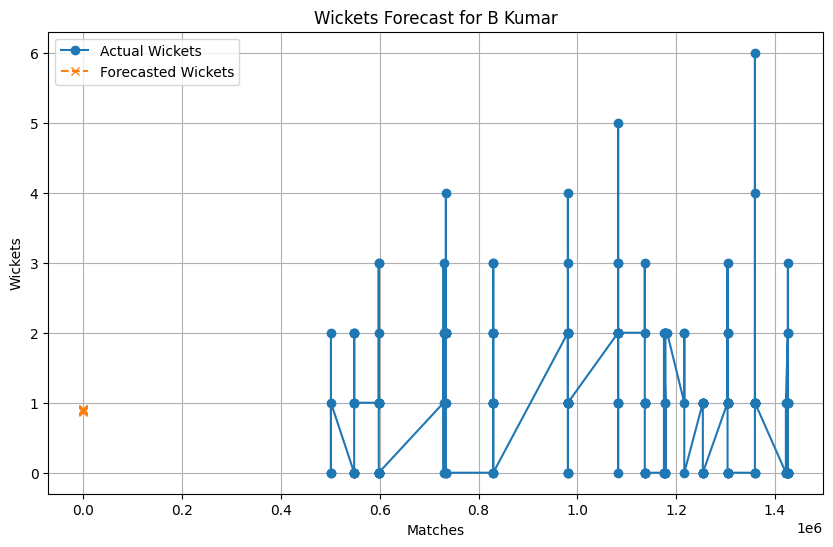

Forecasted wickets for B Kumar in the next 10 matches:
176    0.877525
177    0.874279
178    0.911221
179    0.883362
180    0.905728
181    0.887843
182    0.902148
183    0.890706
184    0.899858
185    0.892538
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

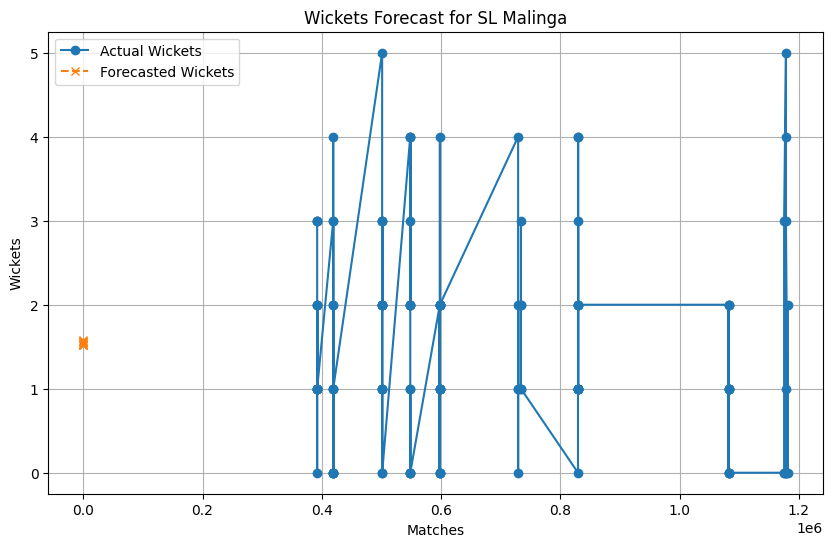

Forecasted wickets for SL Malinga in the next 10 matches:
122    1.581432
123    1.518914
124    1.564134
125    1.522899
126    1.560225
127    1.526430
128    1.557028
129    1.529325
130    1.554407
131    1.531698
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

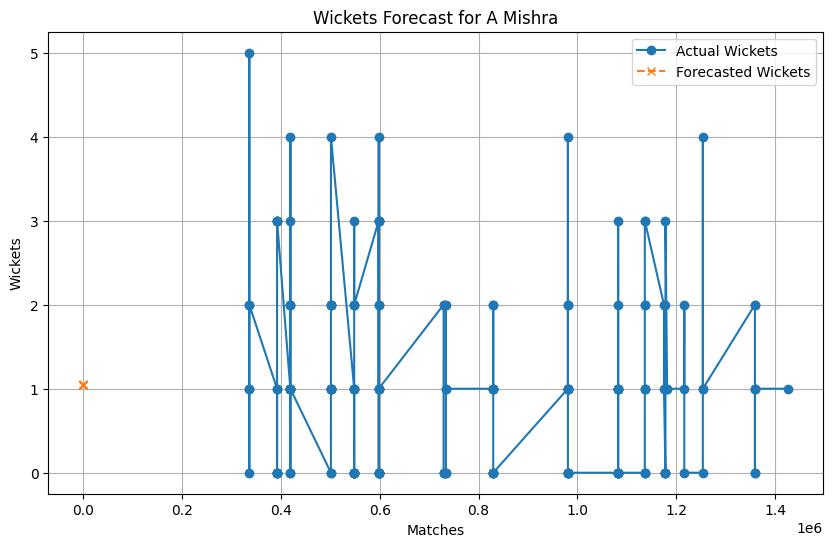

Forecasted wickets for A Mishra in the next 10 matches:
162    1.045904
163    1.048600
164    1.050283
165    1.050112
166    1.050221
167    1.050194
168    1.050204
169    1.050201
170    1.050202
171    1.050201
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

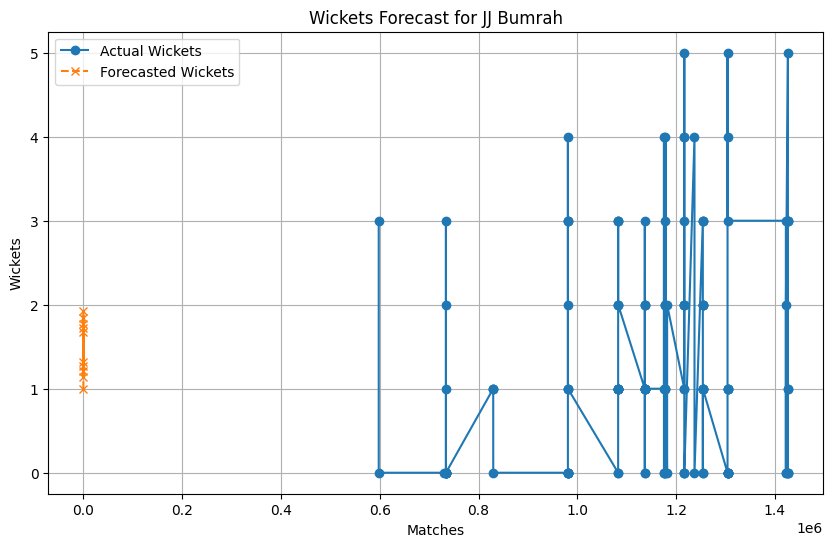

Forecasted wickets for JJ Bumrah in the next 10 matches:
133    0.997069
134    1.919465
135    1.140515
136    1.836433
137    1.212461
138    1.772049
139    1.270195
140    1.720272
141    1.316630
142    1.678627
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

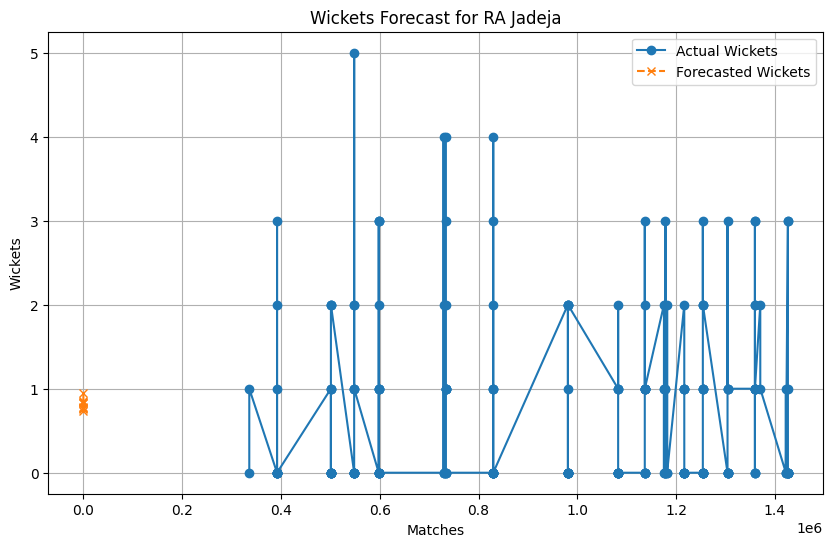

Forecasted wickets for RA Jadeja in the next 10 matches:
211    0.950512
212    0.729462
213    0.858578
214    0.753210
215    0.843794
216    0.765415
217    0.833286
218    0.774509
219    0.825411
220    0.781329
Name: predicted_mean, dtype: float64


In [36]:
for bowler_name in top_bowlers['bowler']:
    bowler_timeseries = performance[performance['bowler'] == bowler_name].set_index('match_id')['wickets']
    bowler_timeseries = bowler_timeseries.sort_index()

    # Train an ARIMA model
    try:
        model = ARIMA(bowler_timeseries, order=(2, 1, 2))
        model_fit = model.fit()
        forecast_steps = 10  # Forecast for the next 10 matches
        forecast = model_fit.forecast(steps=forecast_steps)

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(bowler_timeseries, label='Actual Wickets', marker='o')
        plt.plot(range(len(bowler_timeseries), len(bowler_timeseries) + forecast_steps),
                 forecast, label='Forecasted Wickets', marker='x', linestyle='--')
        plt.title(f'Wickets Forecast for {bowler_name}')
        plt.xlabel('Matches')
        plt.ylabel('Wickets')
        plt.legend()
        plt.grid(True)
        plt.show()

        print(f"Forecasted wickets for {bowler_name} in the next {forecast_steps} matches:")
        print(forecast)

    except Exception as e:
        print(f"Error processing {bowler_name}: {e}")

Using sarima model for forecasting best bowler and batsman

In [37]:
# Function to forecast using SARIMA
def forecast_sarima(timeseries, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
    try:
        model = SARIMAX(timeseries, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=5) # Forecast for the next 5 matches
        return forecast
    except Exception as e:
        print(f"Error fitting SARIMA model: {e}")
        return None

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_

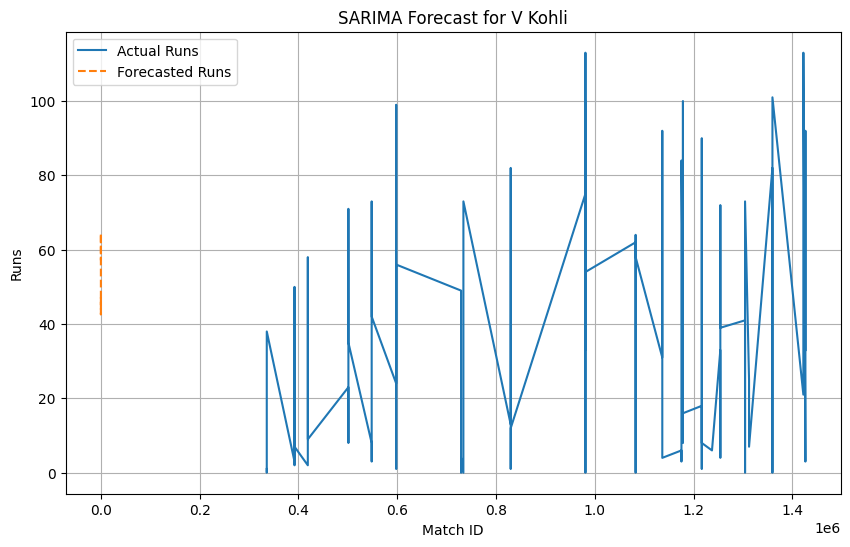

Forecasted runs for V Kohli: [47.16748587 46.35560027 42.56871891 64.38416103 57.14086707]
Mean Absolute Error (MAE): 21.581126519741648
Root Mean Squared Error (RMSE): 25.44598067457984
Mean Absolute Percentage Error (MAPE): 45.94%
R-squared (R2): 0.01


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index

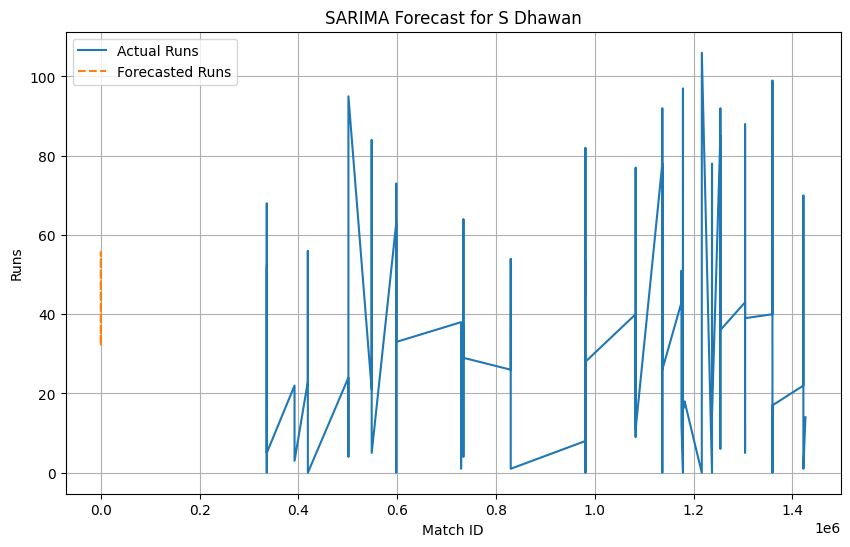

Forecasted runs for S Dhawan: [32.19068721 55.68730317 41.08047697 32.85875633 34.79368871]
Mean Absolute Error (MAE): 20.489991691532726
Root Mean Squared Error (RMSE): 22.368572652660347
Mean Absolute Percentage Error (MAPE): 689.16%
R-squared (R2): 0.35


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index

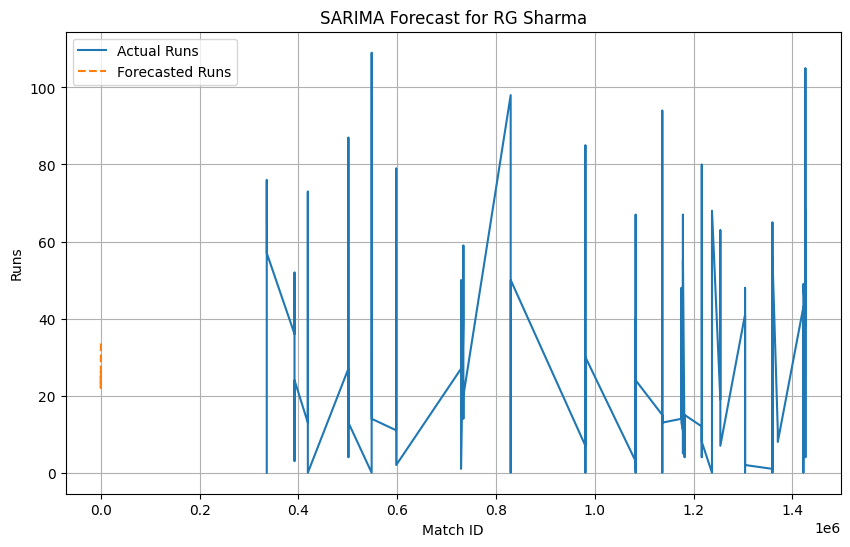

Forecasted runs for RG Sharma: [26.39983919 22.03450907 25.14286498 22.05162239 34.35832072]
Mean Absolute Error (MAE): 18.25410298193768
Root Mean Squared Error (RMSE): 21.03144745307302
Mean Absolute Percentage Error (MAPE): 250.88%
R-squared (R2): 0.68


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_

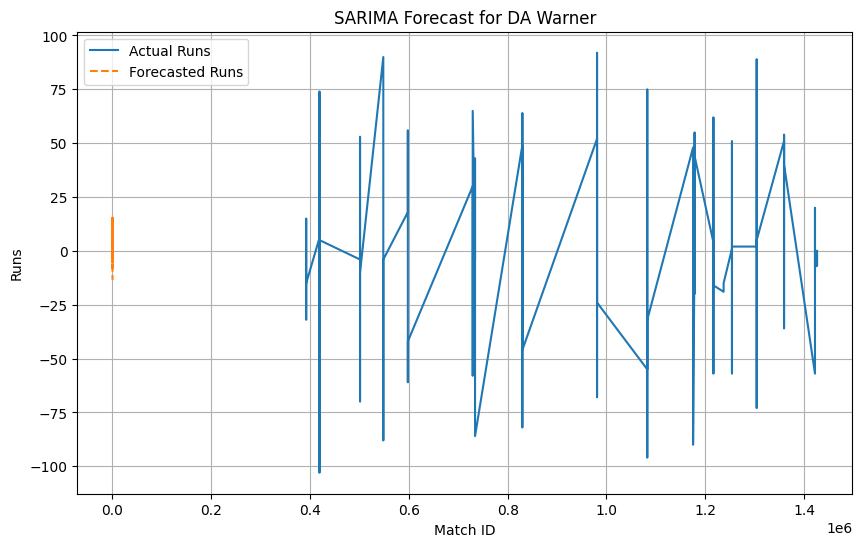

Forecasted runs for DA Warner: [ -8.33588509  15.43768659  -5.20710652  15.71106586 -13.43732286]
Mean Absolute Error (MAE): 17.69145934818618
Root Mean Squared Error (RMSE): 19.568401249885994
Mean Absolute Percentage Error (MAPE): inf%
R-squared (R2): 0.02


<ipython-input-38-5d069cf6e26c>:36: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual_runs - forecast_runs) / actual_runs)) * 100  # avoid division by zero
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/li

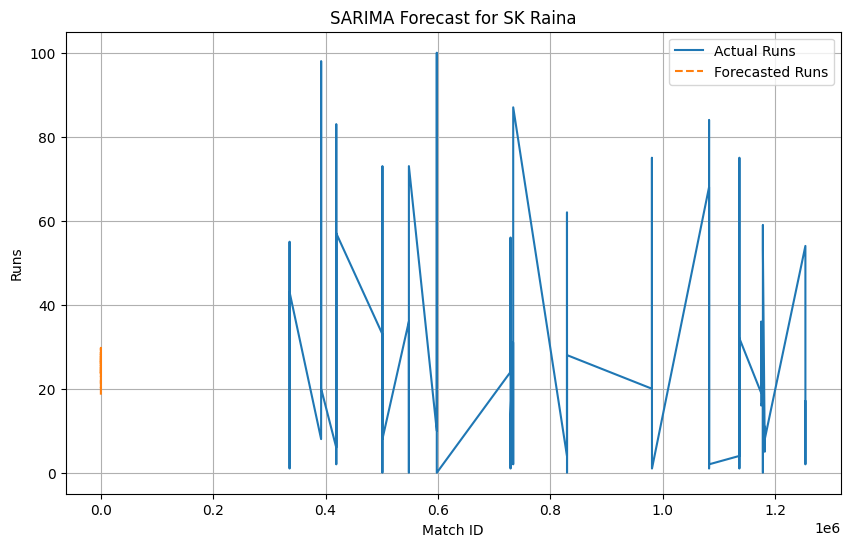

Forecasted runs for SK Raina: [18.5800284  29.73713344 23.62357626 28.6516902  19.74828974]
Mean Absolute Error (MAE): 16.66814360826418
Root Mean Squared Error (RMSE): 18.90343598516463
Mean Absolute Percentage Error (MAPE): 530.68%
R-squared (R2): 0.25


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index

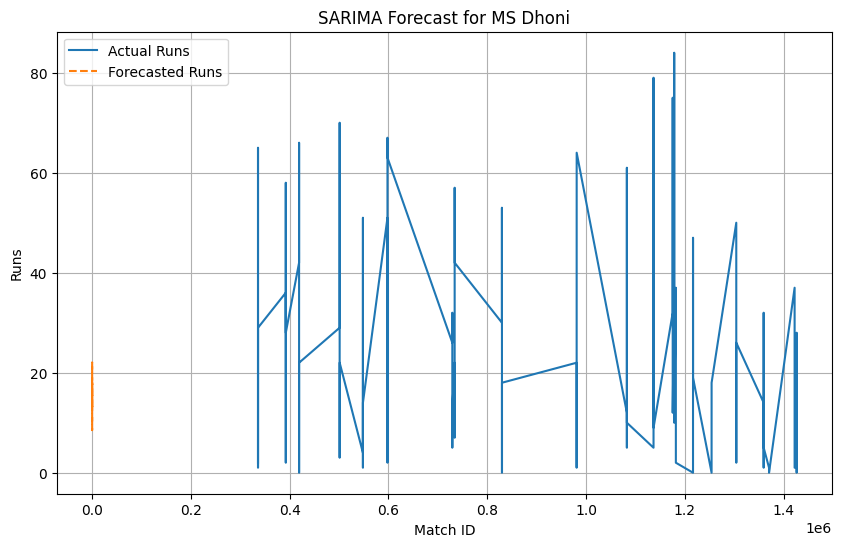

Forecasted runs for MS Dhoni: [13.12778655 22.0693018   8.49922513 18.00398901 12.38397856]
Mean Absolute Error (MAE): 9.061669180438926
Root Mean Squared Error (RMSE): 9.235925099042023
Mean Absolute Percentage Error (MAPE): inf%
R-squared (R2): 0.22


<ipython-input-38-5d069cf6e26c>:36: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual_runs - forecast_runs) / actual_runs)) * 100  # avoid division by zero
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/li

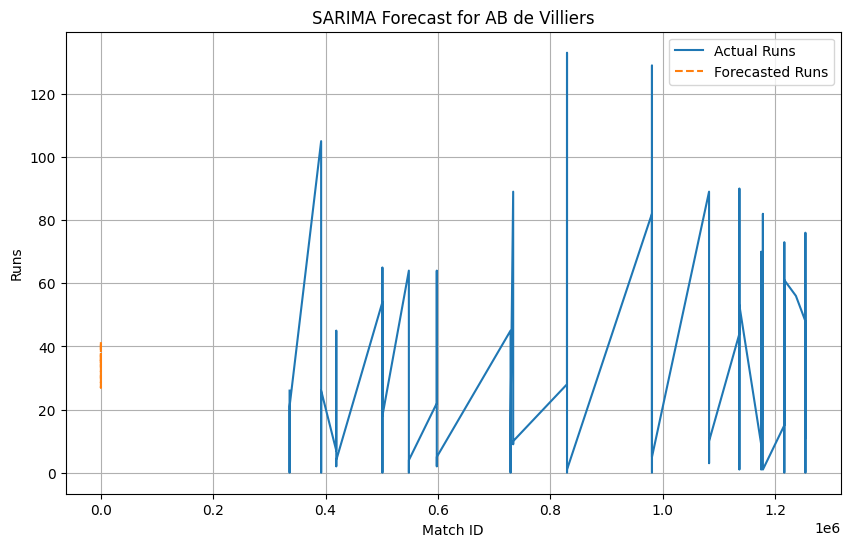

Forecasted runs for AB de Villiers: [34.68031867 41.50975579 35.70762694 26.84774915 37.71671324]
Mean Absolute Error (MAE): 22.492432758115438
Root Mean Squared Error (RMSE): 24.605019658269857
Mean Absolute Percentage Error (MAPE): 312.47%
R-squared (R2): 0.12


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index

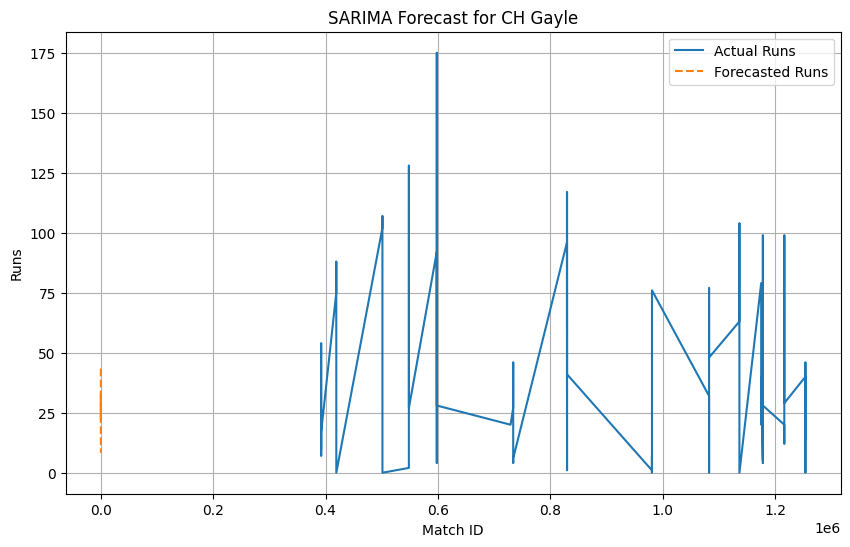

Forecasted runs for CH Gayle: [43.39776024 21.91615249 32.89240406 19.7588324   8.29791648]
Mean Absolute Error (MAE): 22.36698554541959
Root Mean Squared Error (RMSE): 25.469639154487645
Mean Absolute Percentage Error (MAPE): inf%
R-squared (R2): 0.09


<ipython-input-38-5d069cf6e26c>:36: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual_runs - forecast_runs) / actual_runs)) * 100  # avoid division by zero
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/li

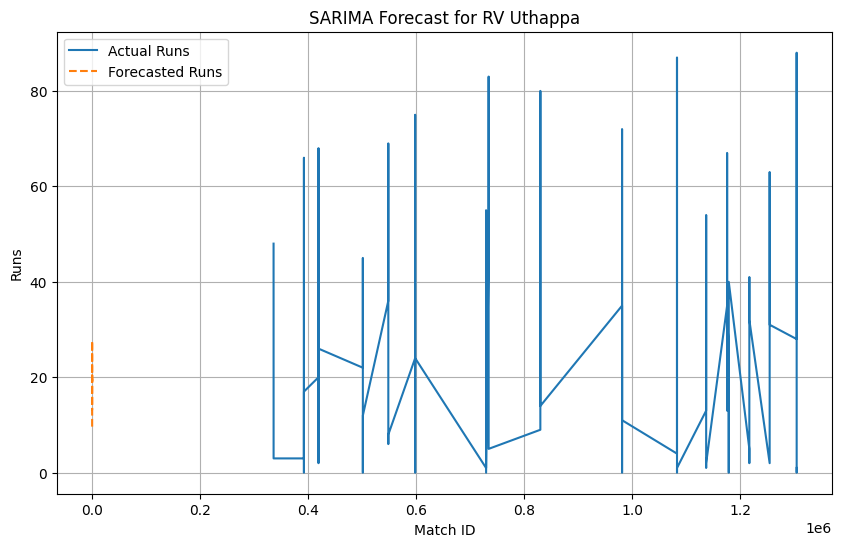

Forecasted runs for RV Uthappa: [ 9.65857158 20.45369024 19.13135311 27.60888799 13.11193577]
Mean Absolute Error (MAE): 19.52945910549597
Root Mean Squared Error (RMSE): 20.149021930146574
Mean Absolute Percentage Error (MAPE): inf%
R-squared (R2): 0.48


<ipython-input-38-5d069cf6e26c>:36: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual_runs - forecast_runs) / actual_runs)) * 100  # avoid division by zero
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/li

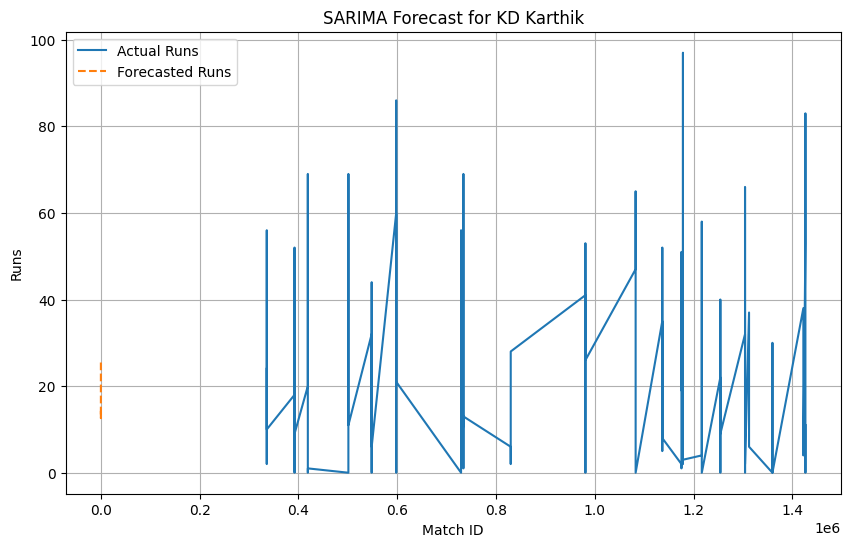

Forecasted runs for KD Karthik: [14.28059144 14.12550589 12.60047736 20.56729578 25.66205204]
Mean Absolute Error (MAE): 8.8847455666557
Root Mean Squared Error (RMSE): 9.767695012935954
Mean Absolute Percentage Error (MAPE): inf%
R-squared (R2): 0.00


<ipython-input-38-5d069cf6e26c>:36: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual_runs - forecast_runs) / actual_runs)) * 100  # avoid division by zero


In [38]:
# Forecasting for Batsmen
for batsman_name in top_10_batsmen['batter']:
    batsman_data = batsman_scores[batsman_scores['batter'] == batsman_name].set_index('match_id')['batsman_runs']
    batsman_data = batsman_data.sort_index()

    # Stationarity Check
    adf_result = adfuller(batsman_data)
    if adf_result[1] > 0.05:
        batsman_data = batsman_data.diff().dropna()

    forecast = forecast_sarima(batsman_data)

    if forecast is not None:
        plt.figure(figsize=(10, 6))
        plt.plot(batsman_data, label='Actual Runs')
        plt.plot(forecast, label='Forecasted Runs', linestyle='--')
        plt.title(f'SARIMA Forecast for {batsman_name}')
        plt.xlabel('Match ID')
        plt.ylabel('Runs')
        plt.legend()
        plt.grid(True)
        plt.show()

        print(f"Forecasted runs for {batsman_name}: {forecast.values}")

        actual_runs = batsman_data.tail(len(forecast)).values
        forecast_runs = forecast.values

        mae = np.mean(np.abs(actual_runs - forecast_runs))
        print(f"Mean Absolute Error (MAE): {mae}")

        rmse = np.sqrt(np.mean((actual_runs - forecast_runs) ** 2))
        print(f"Root Mean Squared Error (RMSE): {rmse}")

        # Mean Absolute Percentage Error (MAPE)
        mape = np.mean(np.abs((actual_runs - forecast_runs) / actual_runs)) * 100  # avoid division by zero
        print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

        # R-squared (R2)
        correlation_matrix = np.corrcoef(actual_runs, forecast_runs)
        correlation_xy = correlation_matrix[0, 1]
        r_squared = correlation_xy**2
        print(f"R-squared (R2): {r_squared:.2f}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index

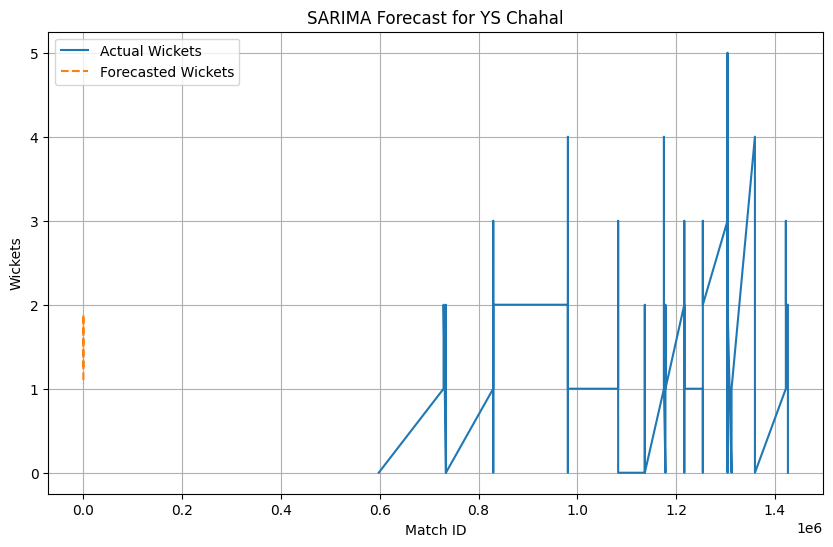

Forecasted wickets for YS Chahal: [1.25610282 1.88280108 1.35016045 1.21926384 1.06076165]
Mean Absolute Error (MAE): 0.6137537887049682
Root Mean Squared Error (RMSE): 0.6986429353641902
Mean Absolute Percentage Error (MAPE): inf%
R-squared (R2): 0.11


<ipython-input-39-d09024587a9a>:30: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual_runs - forecast_runs) / actual_runs)) * 100  # avoid division by zero
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/li

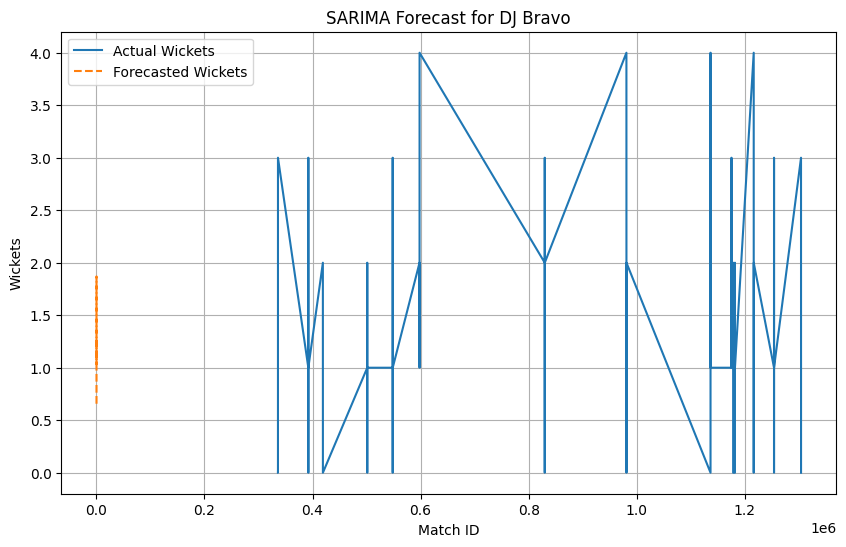

Forecasted wickets for DJ Bravo: [0.65714891 1.05040421 1.86953691 1.03429222 1.26385652]
Mean Absolute Error (MAE): 1.3304948539393882
Root Mean Squared Error (RMSE): 1.4281845133990703
Mean Absolute Percentage Error (MAPE): inf%
R-squared (R2): 0.00


<ipython-input-39-d09024587a9a>:30: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual_runs - forecast_runs) / actual_runs)) * 100  # avoid division by zero
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/li

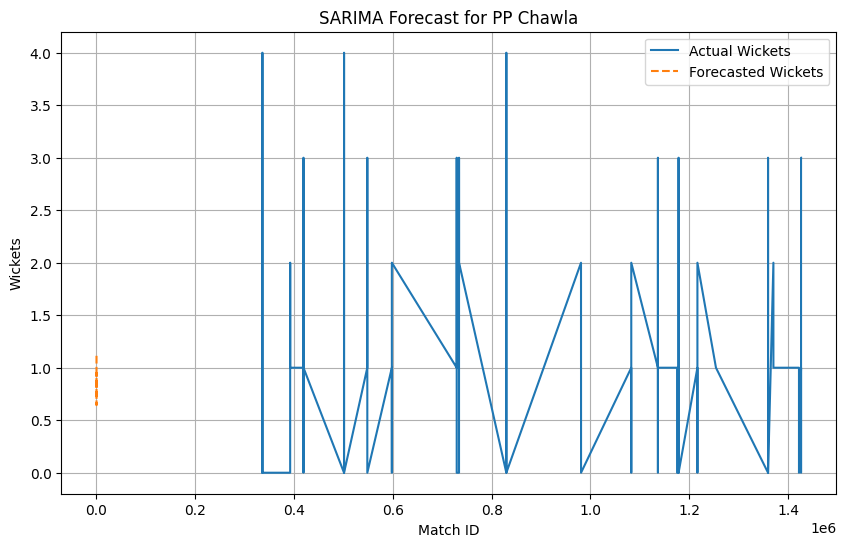

Forecasted wickets for PP Chawla: [1.11331949 0.75188164 0.95163643 0.64329816 0.77559795]
Mean Absolute Error (MAE): 1.398181060436857
Root Mean Squared Error (RMSE): 1.5675101694600104
Mean Absolute Percentage Error (MAPE): inf%
R-squared (R2): 0.17


<ipython-input-39-d09024587a9a>:30: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual_runs - forecast_runs) / actual_runs)) * 100  # avoid division by zero
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/li

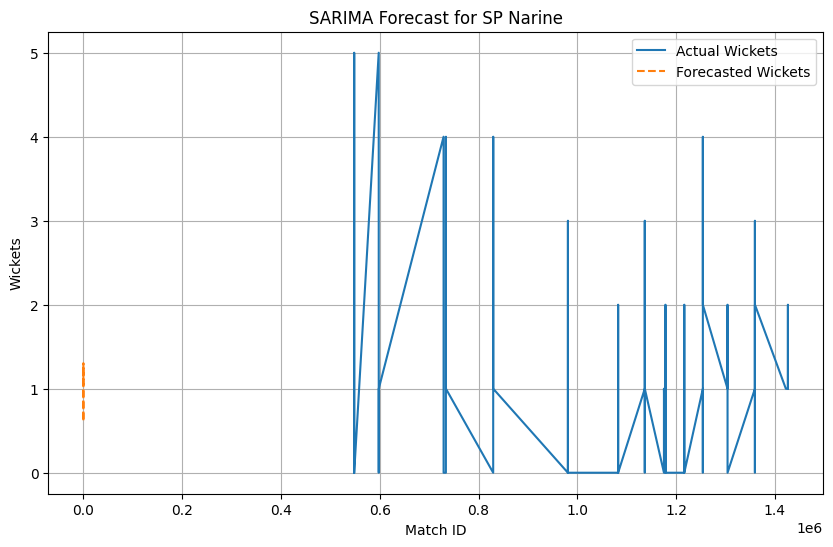

Forecasted wickets for SP Narine: [1.25473608 0.61094699 0.71010864 1.30470594 1.04790373]
Mean Absolute Error (MAE): 0.4334812166509135
Root Mean Squared Error (RMSE): 0.5052813390404336
Mean Absolute Percentage Error (MAPE): 28.94%
R-squared (R2): 0.73


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index

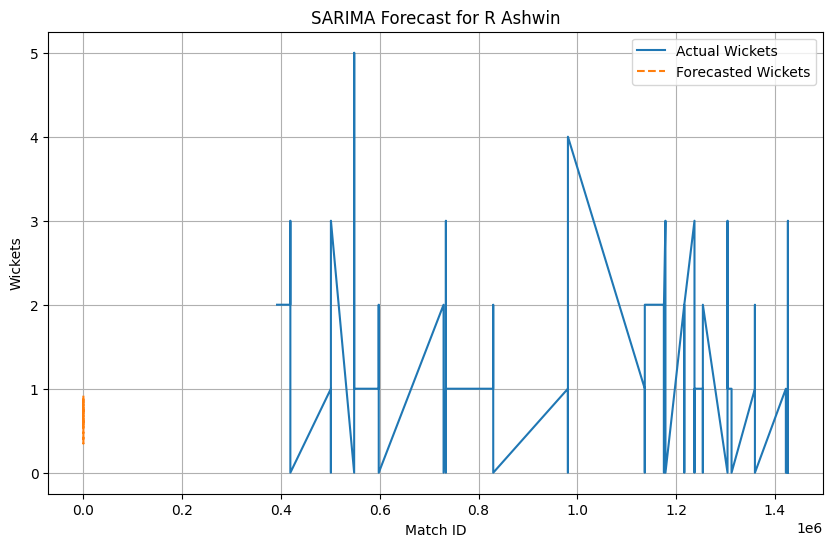

Forecasted wickets for R Ashwin: [0.82124914 0.34556298 0.91922572 0.64099397 0.5320188 ]
Mean Absolute Error (MAE): 1.3286876843157487
Root Mean Squared Error (RMSE): 1.4463080209649275
Mean Absolute Percentage Error (MAPE): inf%
R-squared (R2): 0.01


<ipython-input-39-d09024587a9a>:30: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual_runs - forecast_runs) / actual_runs)) * 100  # avoid division by zero
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/li

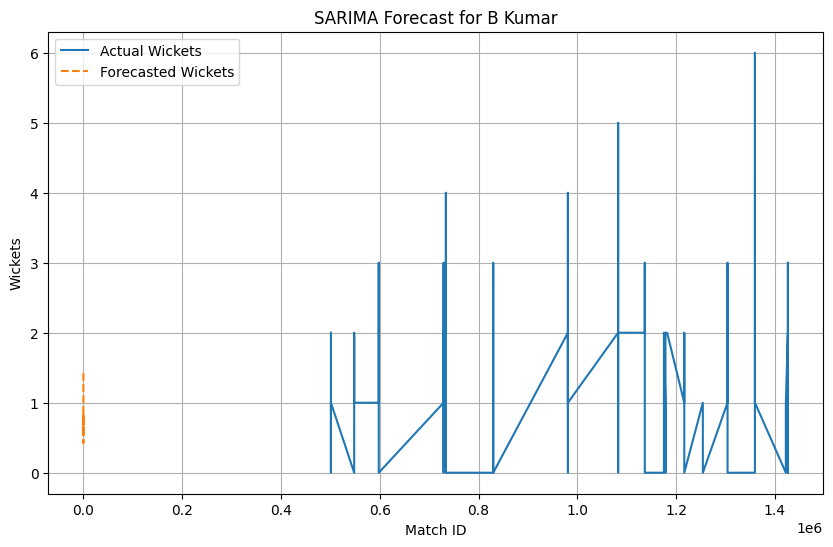

Forecasted wickets for B Kumar: [1.42268622 0.42242139 0.82984692 0.56014528 0.84016353]
Mean Absolute Error (MAE): 0.645978179050387
Root Mean Squared Error (RMSE): 0.6663354144852854
Mean Absolute Percentage Error (MAPE): inf%
R-squared (R2): 0.78


<ipython-input-39-d09024587a9a>:30: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual_runs - forecast_runs) / actual_runs)) * 100  # avoid division by zero
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/li

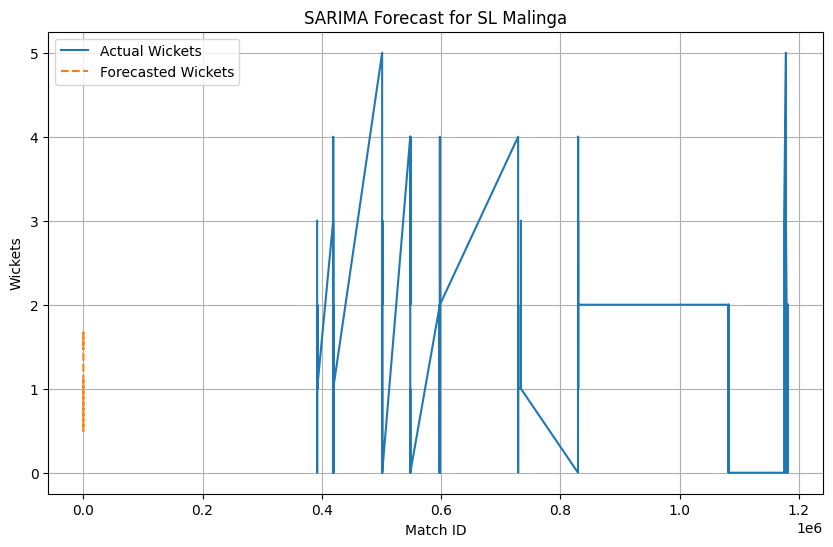

Forecasted wickets for SL Malinga: [1.10113449 0.49518242 1.27015692 1.6734459  1.45985322]
Mean Absolute Error (MAE): 1.1079505358574147
Root Mean Squared Error (RMSE): 1.2281888798513083
Mean Absolute Percentage Error (MAPE): inf%
R-squared (R2): 0.08


<ipython-input-39-d09024587a9a>:30: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual_runs - forecast_runs) / actual_runs)) * 100  # avoid division by zero
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/li

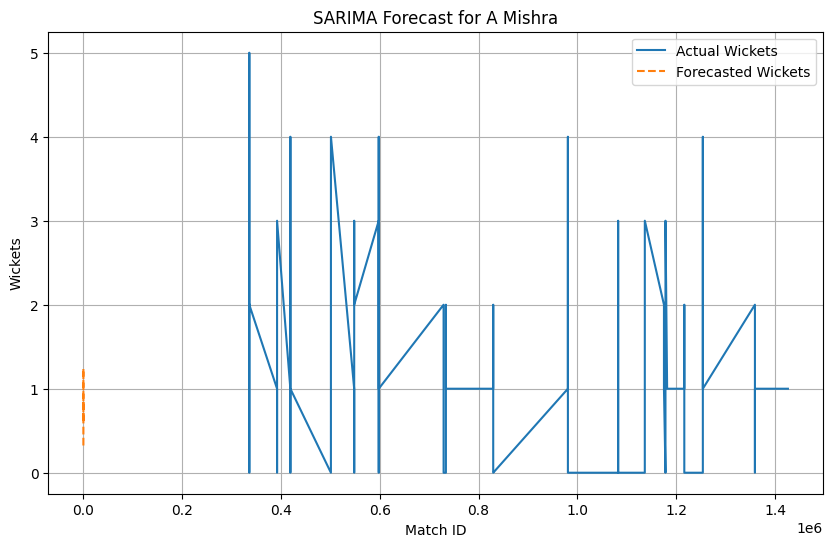

Forecasted wickets for A Mishra: [0.32421703 1.23953102 0.88813571 0.59763983 0.87853168]
Mean Absolute Error (MAE): 0.7102013534903409
Root Mean Squared Error (RMSE): 0.8253496503478969
Mean Absolute Percentage Error (MAPE): inf%
R-squared (R2): 0.13


<ipython-input-39-d09024587a9a>:30: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual_runs - forecast_runs) / actual_runs)) * 100  # avoid division by zero
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/li

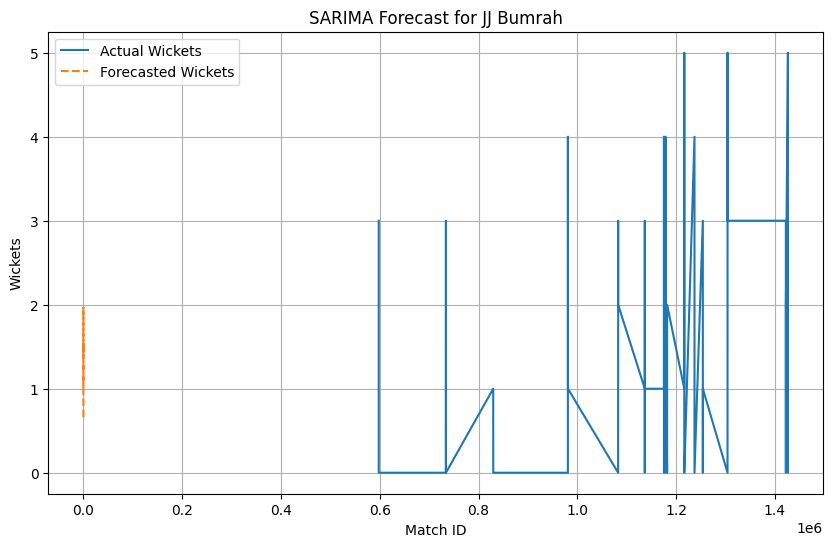

Forecasted wickets for JJ Bumrah: [0.66134977 1.55665029 1.41645545 1.96801284 1.01545761]
Mean Absolute Error (MAE): 1.2862800599561095
Root Mean Squared Error (RMSE): 1.4086102943248546
Mean Absolute Percentage Error (MAPE): inf%
R-squared (R2): 0.06


<ipython-input-39-d09024587a9a>:30: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual_runs - forecast_runs) / actual_runs)) * 100  # avoid division by zero
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/li

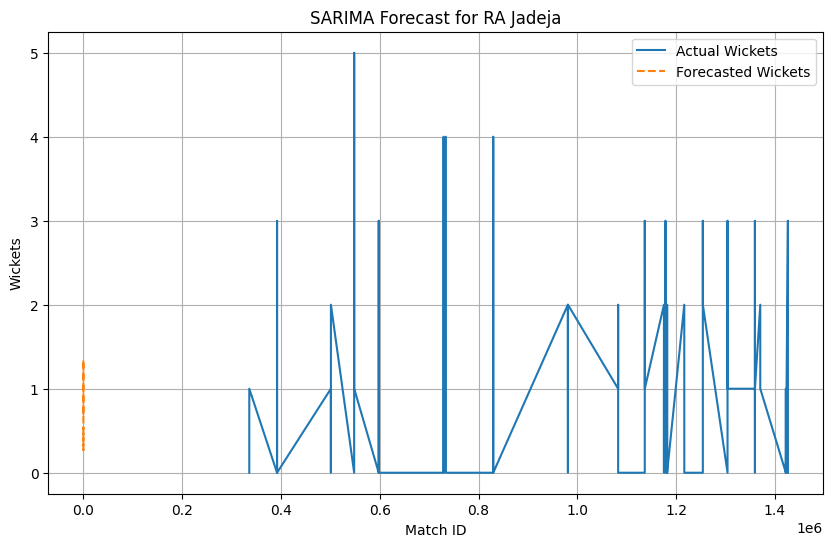

Forecasted wickets for RA Jadeja: [0.69066118 1.03116007 1.34170528 0.26736056 0.54827631]
Mean Absolute Error (MAE): 0.9633686543963403
Root Mean Squared Error (RMSE): 1.1424189422319464
Mean Absolute Percentage Error (MAPE): inf%
R-squared (R2): 0.12


<ipython-input-39-d09024587a9a>:30: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((actual_runs - forecast_runs) / actual_runs)) * 100  # avoid division by zero


In [39]:
# Forecasting for Bowlers
for bowler_name in top_bowlers['bowler']:
    bowler_timeseries = performance[performance['bowler'] == bowler_name].set_index('match_id')['wickets']
    bowler_timeseries = bowler_timeseries.sort_index()

    forecast = forecast_sarima(bowler_timeseries)
    if forecast is not None:
        plt.figure(figsize=(10, 6))
        plt.plot(bowler_timeseries, label='Actual Wickets')
        plt.plot(forecast, label='Forecasted Wickets', linestyle='--')
        plt.title(f'SARIMA Forecast for {bowler_name}')
        plt.xlabel('Match ID')
        plt.ylabel('Wickets')
        plt.legend()
        plt.grid(True)
        plt.show()

        print(f"Forecasted wickets for {bowler_name}: {forecast.values}")

        actual_runs = bowler_timeseries.tail(len(forecast)).values
        forecast_runs = forecast.values

        mae = np.mean(np.abs(actual_runs - forecast_runs))
        print(f"Mean Absolute Error (MAE): {mae}")

        rmse = np.sqrt(np.mean((actual_runs - forecast_runs) ** 2))
        print(f"Root Mean Squared Error (RMSE): {rmse}")

        # Mean Absolute Percentage Error (MAPE)
        mape = np.mean(np.abs((actual_runs - forecast_runs) / actual_runs)) * 100  # avoid division by zero
        print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

        # R-squared (R2)
        correlation_matrix = np.corrcoef(actual_runs, forecast_runs)
        correlation_xy = correlation_matrix[0, 1]
        r_squared = correlation_xy**2
        print(f"R-squared (R2): {r_squared:.2f}")
